In [3]:
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import TFBertModel, BertTokenizer
import numpy as np
import pandas as pd
import spacy
import re
from tqdm import tqdm

!python -m spacy download de_core_news_sm
# Load the German language model from SpaCy
nlp = spacy.load('de_core_news_sm')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 76.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
def create_custom_bert_model(vocab_size=30000):
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="input_word_ids")
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="token_type_ids")

    # Load the pretrained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Modify the embeddings to match the provided weights
    bert_model.resize_token_embeddings(vocab_size)
    
    sequence_output = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]

    cls_token = sequence_output[:, 0, :]
    dense_output = tf.keras.layers.Dense(1, activation='sigmoid', name='dense')(cls_token)

    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense_output)
    return model

# Create the model
model = create_custom_bert_model()

# Load the weights from the .h5 file
h5_file_path = '/kaggle/input/political-detection/bert_lemmatisation_no_stopwords.h5'
model.load_weights(h5_file_path)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                            

In [6]:
def clean_transcript(transcript):
    # Remove text within square brackets
    cleaned_text = re.sub(r'\[.*?\]', '', transcript)
    # Remove additional unwanted patterns, e.g., URLs, special characters, etc.
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', cleaned_text, flags=re.MULTILINE)
    cleaned_text = re.sub(r'[^a-zA-Zäöüß ]', '', cleaned_text)
    return cleaned_text.lower()

# Function to preprocess the text
def preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    preprocessed_text = " ".join(lemmatized_tokens)
    return preprocessed_text

# Function to classify text
def classify_text(text):
    tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
    preprocessed_text = preprocess_text(text)
    inputs = tokenizer(preprocessed_text, return_tensors="tf", padding="max_length", max_length=512, truncation=True)
    
    outputs = model([inputs["input_ids"], inputs["attention_mask"], inputs["token_type_ids"]])
    probability = outputs.numpy()[0][0]
    return probability

# Example usage
example_text = "Dies ist ein Beispieltext über die deutsche Bundestag Ukraine Putin."
classification_probability = classify_text(example_text)
print(f"The probability of the text being political is: {classification_probability}")



tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

The probability of the text being political is: 0.8875925540924072


In [7]:
df = pd.read_csv("/kaggle/input/youtube/videos_all.csv")
df

,channel_id,channel_name,channel_leaning,video_id,video_title,video_published_at,transcript
0,UCOQFfcGRc886dXP2Oyt5OEg,Tim Kellner,right,XBM5lWJmkic,❗️❗️❗️ ATTENTAT auf Michael Stürzenberger ‼️💥P...,2024-05-31T11:36:54Z,breaking new ja furchtbare Nachrichten ein seh...
1,UCOQFfcGRc886dXP2Oyt5OEg,Tim Kellner,right,nldhq-JyRBQ,STERN-Journalist blamiert sich UNENDLICH! 💥⚡️|...,2024-05-30T17:51:52Z,wird immer lustiger im shitol zerstören ist ei...
2,UCOQFfcGRc886dXP2Oyt5OEg,Tim Kellner,right,397nMhb84hA,SKANDAL-Entgleisung: „Freispruch für Höcke?“ 💥...,2024-05-29T17:10:49Z,oh yes heute menstrual Hygiene day geil wichti...
3,UCOQFfcGRc886dXP2Oyt5OEg,Tim Kellner,right,0aTLDQFI55o,SENDUNG entgleitet Moderator TOTAL! 💥⚡️| hart ...,2024-05-28T17:22:08Z,noch mal bedrohlich D D Gigi Agostino erobert ...
4,UCOQFfcGRc886dXP2Oyt5OEg,Tim Kellner,right,pK9K6kQel1M,SYLT oder „DIESES Land ist moralisch völlig am...,2024-05-27T06:01:15Z,[Musik] [Musik] ja Freunde jetzt mal ohne Sche...
...,...,...,...,...,...,...,...
5654,UCF_oOFgq8qwi7HRGTJSsZ-g,Datteltäter,left,i4olbPuleck,FLUCHTURLAUB IM HEIMATLAND - jetzt buchen!!!,2017-05-05T13:01:02Z,"Ah, ein neuer Post von der AfD: Das ist ja der..."
5655,UCF_oOFgq8qwi7HRGTJSsZ-g,Datteltäter,left,sy0l22ve59I,Talkshow Gast: ISLAMEXPERTE - Das große Casting!,2017-04-28T13:02:58Z,"Ah, Micha, du merkst doch\ngerade, was abgeht...."
5656,UCF_oOFgq8qwi7HRGTJSsZ-g,Datteltäter,left,RcVekqK9Neo,13 Dinge die Kopftuchtragende Frauen kennen (T...,2017-04-21T13:00:03Z,"*Vogelgezwitscher* What? *Musik* Hi! - Hey, sc..."
5657,UCF_oOFgq8qwi7HRGTJSsZ-g,Datteltäter,left,qq7oVq4uBG0,Wie man Muslime auch kennenlernen kann,2017-04-14T13:00:04Z,(Scheppern) (Scheppern und Stimmengewirr) Der ...


In [8]:
# Apply cleaning to the "transcript" column
df['cleaned_transcript'] = df['transcript'].apply(clean_transcript)

In [10]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example usage: classify a list of transcripts
import pandas as pd


# Ensure the model runs on GPU if available
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
with tf.device(device):
    probs = []
    for transcript in tqdm(df['cleaned_transcript'], desc="Classifying transcripts"):
        pol_prob = classify_text(transcript)
        probs.append(pol_prob)
    df['political_probability'] = probs

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Classifying transcripts: 100%|██████████| 5659/5659 [1:17:03<00:00,  1.22it/s]  


In [11]:
df.to_csv("videos_all.csv", index = False)

In [13]:
df['political_probability']

0       0.362124
1       0.676739
2       0.773986
3       0.687639
4       0.273171
          ...   
5654    0.074164
5655    0.850104
5656    0.015041
5657    0.021943
5658    0.009697
Name: political_probability, Length: 5659, dtype: float32

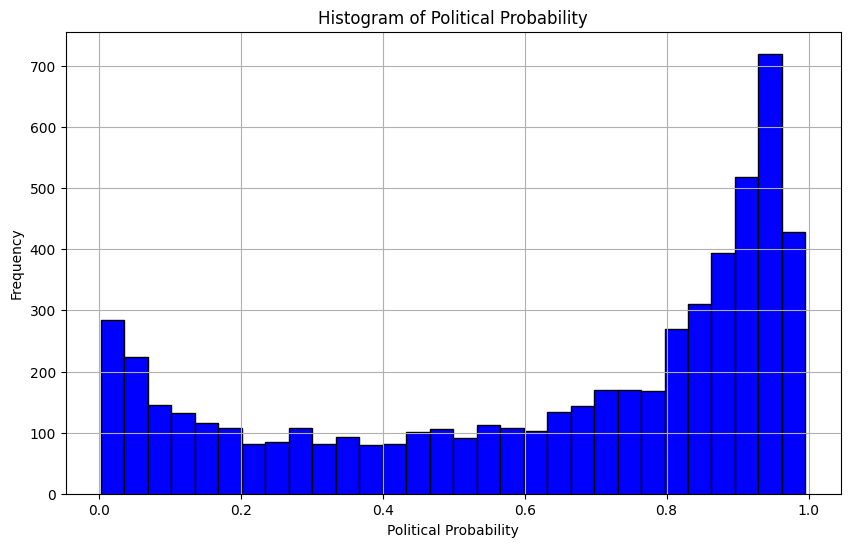

In [14]:
import matplotlib.pyplot as plt
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['political_probability'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Political Probability')
plt.xlabel('Political Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()